## Scenario loading and structure 

`GPUDrive` is a multi-agent driving simulator built on top of the [Waymo Open Motion Dataset (WOMD)](https://waymo.com/open/). 


In this tutorial, we show how to load scenario data from WOMD into `GPUDrive` and explain the structure of a traffic scenario.

In [4]:
# Dependencies
import json
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import pandas as pd

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

cmap = ["r", "g", "b", "y", "c"]
%config InlineBackend.figure_format = 'svg'
sns.set("notebook", font_scale=1.1, rc={"figure.figsize": (8, 3)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})

### How to make the simulator using a set of scenarios

For convenience, we uploaded a folder containing three scenarios in the `data` directory that you can work with. The full dataset can be downloaded [here](https://github.com/Emerge-Lab/gpudrive/tree/main?tab=readme-ov-file#dataset). Notice that the data folder is structured as follows:

```bash
data/
    - tfrecord-xxxxx-of-xxxxx
    - ....
    - tfrecord-xxxxx-of-xxxxx
```

Every file beginning with `tfrecord` represents a unique traffic scenario.

To run an experiment using only a subset of the scenarios in a folder, you can use `SceneConfig` to control the sampling of traffic scenes. The settings in the scene config are used by `select_scenes()` to generate a list of file paths for the simulator.

Let's import `gpudrive` to create the simulator with the provided data:

In [6]:
import gpudrive

from pygpudrive.env.config import SceneConfig
from pygpudrive.env.scene_selector import select_scenes

scene_config = SceneConfig(path="data/processed/examples", num_scenes=1)

sim = gpudrive.SimManager( # Specify the execution mode: CUDA or CPU
    exec_mode=gpudrive.madrona.ExecMode.CPU, #gpudrive.madrona.ExecMode.CUDA
    gpu_id=0,
    scenes=select_scenes(scene_config),
    params=gpudrive.Parameters(),  # Environment parameters
)


--- Ratio unique scenes / number of worls = 1 / 1 ---



### What is inside a traffic scenario? 🤔🔬

Though every scenario in the WOMD is unique, they all share the same basic data structure. Traffic scenarios are essentially dictionaries, which you can inspect using tools like [JSON Formatter](https://jsonformatter.org/json-viewer). We'll also look at one in this notebook. In a nutshell, traffic scenarios contain a few important key elements:

- **Road map**: The layout and structure of the roads.
- **Human driving (expert) demonstrations**: Examples of human driving behavior.
- **Road objects**: Elements such as stop signs and other traffic signals.

In [9]:
# Take an example scene
data_path = "data/processed/examples/tfrecord-00001-of-01000_307.json"

with open(data_path) as file:
    traffic_scene = json.load(file)

traffic_scene.keys()

dict_keys(['name', 'objects', 'roads', 'tl_states'])


We will show you how to render a scene in ⏭️ tutorial `03`, which introduces the gym environment wrapper. Let's first take a closer look at the data structure.

### Global Overview 
A traffic scene consists of:
- `name`: the name of the traffic scenario.
- `objects`: the road objects or moving vehicles in the scene.
- `roads`: the road points in the scene, these are all the stationary objects.
- `tl_states`: the states of the traffic lights, which are filtered out for now. 

In [10]:
traffic_scene["tl_states"]

{}

In [11]:
traffic_scene["name"]

'tfrecord-00001-of-01000_307.json'

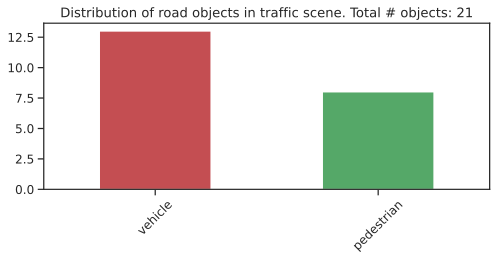

In [12]:
pd.Series(
    [
        traffic_scene["objects"][idx]["type"]
        for idx in range(len(traffic_scene["objects"]))
    ]
).value_counts().plot(kind="bar", rot=45, color=cmap)
plt.title(
    f'Distribution of road objects in traffic scene. Total # objects: {len(traffic_scene["objects"])}'
)
plt.show()

This traffic scenario only contains vehicles and pedestrians, some scenes have cyclists as well.

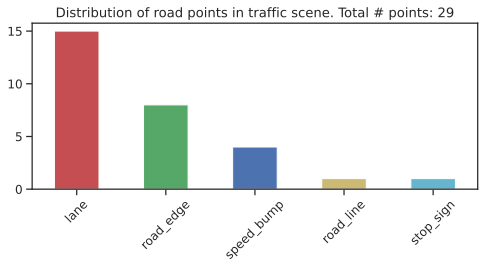

In [13]:
pd.Series(
    [traffic_scene["roads"][idx]["type"] for idx in range(len(traffic_scene["roads"]))]
).value_counts().plot(kind="bar", rot=45, color=cmap)
plt.title(
    f'Distribution of road points in traffic scene. Total # points: {len(traffic_scene["roads"])}'
)
plt.show()

### In-Depth: Road Objects

This is a list of different road objects in the traffic scene. For each road object, we have information about its position, velocity, size, in which direction it's heading, whether it's a valid object, the type, and the final position of the vehicle.

In [14]:
# Take the first object
idx = 0

# For each object, we have this information:
traffic_scene["objects"][idx].keys()

dict_keys(['position', 'width', 'length', 'heading', 'velocity', 'valid', 'goalPosition', 'type'])

In [15]:
# Position contains the (x, y) coordinates for the vehicle at every time step
print(json.dumps(traffic_scene["objects"][idx]["position"][:10], indent=4))

[
    {
        "x": 393.29315185546875,
        "y": 10802.4453125
    },
    {
        "x": 392.44085693359375,
        "y": 10802.2021484375
    },
    {
        "x": 391.6226501464844,
        "y": 10801.9765625
    },
    {
        "x": 390.769287109375,
        "y": 10801.736328125
    },
    {
        "x": 389.92059326171875,
        "y": 10801.50390625
    },
    {
        "x": 389.09722900390625,
        "y": 10801.2783203125
    },
    {
        "x": 388.2420959472656,
        "y": 10801.04296875
    },
    {
        "x": 387.41168212890625,
        "y": 10800.8193359375
    },
    {
        "x": 386.5860595703125,
        "y": 10800.5947265625
    },
    {
        "x": 385.7470703125,
        "y": 10800.3740234375
    }
]


In [16]:
# Width and length together make the size of the object, and is used to see if there is a collision
traffic_scene["objects"][idx]["width"], traffic_scene["objects"][idx]["length"]

(2.050861358642578, 4.623200416564941)

An object's heading refers to the direction it is pointing or moving in. The default coordinate system in Nocturne is right-handed, where the positive x and y axes point to the right and downwards, respectively. In a right-handed coordinate system, 0 degrees is located on the x-axis and the angle increases counter-clockwise.

Because the scene is created from the viewpoint of an ego driver, there may be instances where the heading of certain vehicles is not available. These cases are represented by the value `-10_000`, to indicate that these steps should be filtered out or are invalid.

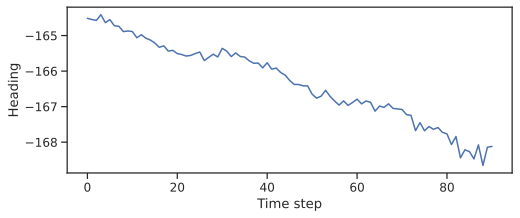

In [17]:
# Heading is the direction in which the vehicle is pointing
plt.plot(traffic_scene["objects"][idx]["heading"])
plt.xlabel("Time step")
plt.ylabel("Heading")
plt.show()

In [18]:
# Velocity shows the velocity in the x- and y- directions
print(json.dumps(traffic_scene["objects"][idx]["velocity"][:10], indent=4))

[
    {
        "x": -8.3782958984375,
        "y": -2.255859375
    },
    {
        "x": -8.52294921875,
        "y": -2.431640625
    },
    {
        "x": -8.18206787109375,
        "y": -2.255859375
    },
    {
        "x": -8.53363037109375,
        "y": -2.40234375
    },
    {
        "x": -8.4869384765625,
        "y": -2.32421875
    },
    {
        "x": -8.233642578125,
        "y": -2.255859375
    },
    {
        "x": -8.55133056640625,
        "y": -2.353515625
    },
    {
        "x": -8.30413818359375,
        "y": -2.236328125
    },
    {
        "x": -8.2562255859375,
        "y": -2.24609375
    },
    {
        "x": -8.389892578125,
        "y": -2.20703125
    }
]


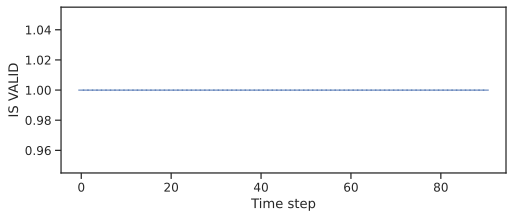

In [19]:
# Valid indicates if the state of the vehicle was observed for each timepoint
plt.xlabel("Time step")
plt.ylabel("IS VALID")
plt.plot(traffic_scene["objects"][idx]["valid"], "_", lw=5)
plt.show()

In [20]:
# Each object has a goalPosition, an (x, y) position within the scene
traffic_scene["objects"][idx]["goalPosition"]

{'x': 347.3999328613281, 'y': 10790.9677734375}

In [21]:
# Finally, we have the type of the vehicle
traffic_scene["objects"][idx]["type"]

'vehicle'

### In-Depth: Road Points

Road points are static objects in the scene.

In [22]:
traffic_scene["roads"][idx].keys()

dict_keys(['geometry', 'type'])

In [23]:
# This point represents the edge of a road
traffic_scene["roads"][idx]["type"]

'road_edge'

In [24]:
# Geometry contains the (x, y) position(s) for a road point
# Note that this will be a list for road lanes and edges but a single (x, y) tuple for stop signs and alike
print(json.dumps(traffic_scene["roads"][idx]["geometry"][:10], indent=4));

[
    {
        "x": 550.906782557804,
        "y": 10833.126571731626
    },
    {
        "x": 550.4223763265672,
        "y": 10833.13445799042
    },
    {
        "x": 549.9379701098744,
        "y": 10833.142345234306
    },
    {
        "x": 549.4535639077253,
        "y": 10833.15023336635
    },
    {
        "x": 548.9691577187981,
        "y": 10833.158122291983
    },
    {
        "x": 548.4847515417705,
        "y": 10833.166011915062
    },
    {
        "x": 548.000345373998,
        "y": 10833.173902141016
    },
    {
        "x": 547.5159392154808,
        "y": 10833.18179287449
    },
    {
        "x": 547.0315330622522,
        "y": 10833.189684018549
    },
    {
        "x": 546.5465681719085,
        "y": 10833.197583512241
    }
]
